In [1]:
import string
import numbers
import math
import random
import pprint

import numpy as np
import pandas as pd
import cv2 as cv
import scipy
import scipy.special
import scipy.spatial
import scipy.stats
import scipy.stats.qmc
import scipy.ndimage
import shapely
import shapely.geometry
import matplotlib
import matplotlib.patches
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.collections as mc
from matplotlib.path import Path
from tabulate import tabulate
import networkx as nx
import torch

import utility as util
pp = pprint.PrettyPrinter(indent=4)

https://en.wikipedia.org/wiki/Inverse_transform_sampling

1. Generate a random number $u$ from the standard uniform distribution in the interval $[0,1]$, e.g. from $U\sim \mathrm {Unif} [0,1]$..
2. Find the inverse of the desired CDF, e.g.$F_{X}^{-1}(x)$.
3. Compute $X=F_{X}^{-1}(u)$. The computed random variable $X$ has distribution $F_X(x)$.



In [2]:
def sample_pdf(bins, weights, N_samples, det=False):
    """Sample points from B batches of unnormalized piecewise constant distribution
    using inverse transform sampling.
    Based on: https://github.com/yenchenlin/nerf-pytorch
    
    Parameters
    ==========
    bins : torch.Tensor
        The start and end positions of the M 'bins' where distribution is contant. Has shape (B,*,M + 1).
    weights : torch.Tensor
        The unnormalized value of the distribution at each 'bin'. Has shape (B,*,M).
    N_samples : torch.Tensor
        The number of points to sample from distribution for each of the (B,*) batches.
    det : bool
        Deterministically sample from distribution according to weight.
    
    Returns
    =======
    torch.Tensor
        The sampled points of shape (B,*,N_samples).
    """
    weights = weights + 1e-5 # prevent nans
    pdf = weights / torch.sum(weights, -1, keepdim=True)
    cdf = torch.cumsum(pdf, -1)
    cdf = torch.cat([torch.zeros_like(cdf[...,:1]), cdf], -1) # (batch, len(bins))

    # Take uniform samples
    if det:
        u = torch.linspace(0., 1., steps=N_samples)
        u = u.expand(list(cdf.shape[:-1]) + [N_samples])
    else:
        u = torch.rand(list(cdf.shape[:-1]) + [N_samples])

    # Invert CDF
    u = u.contiguous()
    inds = torch.searchsorted(cdf, u, right=True)
    below = torch.max(torch.zeros_like(inds-1), inds-1)
    above = torch.min((cdf.shape[-1] - 1) * torch.ones_like(inds), inds)
    inds_g = torch.stack([below, above], -1)  # (..., N_samples, 2)

    matched_shape = [*inds_g.shape[:-2], inds_g.shape[-2], cdf.shape[-1]]
    cdf_g = torch.gather(cdf.unsqueeze(-2).expand(matched_shape), -1, inds_g)
    bins_g = torch.gather(bins.unsqueeze(-2).expand(matched_shape), -1, inds_g)

    denom = (cdf_g[...,1]-cdf_g[...,0])
    denom = torch.where(denom<1e-5, torch.ones_like(denom), denom)
    t = (u-cdf_g[...,0])/denom
    samples = bins_g[...,0] + t * (bins_g[...,1]-bins_g[...,0])
    return samples

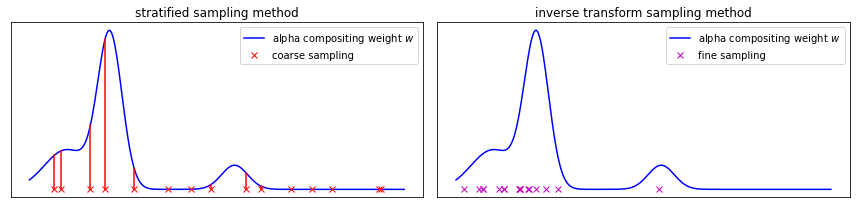

In [3]:
# use sample_pdf() to resample using inverse transform sampling method

class RandDistribution(object):
    def __init__(self):
        self.norms = []
        self.coeffs = []
        for _ in range(random.randint(2, 5)):
            loc = random.uniform(-16, 16)
            scale = random.uniform(0.5, 2)
            norm = scipy.stats.norm(loc=loc, scale=scale)
            self.norms.append(norm)
            self.coeffs.append(random.uniform(0.05, 1.))
    
    def __call__(self, x):
        return sum(map(lambda t: t[0]*t[1].pdf(x), zip(self.coeffs, self.norms)))

# norm1 = scipy.stats.norm(loc=1.8, scale=2)
# norm2 = scipy.stats.norm(loc=-2, scale=1)
# norm3 = scipy.stats.norm(loc=10, scale=1)
# def distribution(x):
#     return 0.3*norm1.pdf(x) + 0.4*norm2.pdf(x) + 0.3*norm3.pdf(x)
distribution = RandDistribution()
# distribution = lambda x: np.zeros(x.shape, dtype=float)

fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(121)

# plot the PDF
x = np.linspace(-16, 16, 1000)
y = distribution(x)
ax.plot(x, y, "-b", label="alpha compositing weight $w$")
_x = x
_y = y

# course samples from the PDF
N = 16
x = np.linspace(-16, 16, N)
should_jiggle_samples = True
if should_jiggle_samples:
    x = np.random.uniform(low=x[:-1] , high=x[1:])

should_test_dups = False
if should_test_dups:
    x[4] = x[3]
    x[5] = x[3]
    x[6] = x[3]
    x[7] = x[3]
    x[8] = x[3]
    x[9] = x[3]
# Gaussian
y = distribution(x)
ax.plot(x, np.zeros(x.size), "rx", label="coarse sampling")
ax.set_title("stratified sampling method")
z = np.vstack((np.zeros(x.size)[None], y[None])).T
for _h, _z in zip(x, z):
    ax.plot([_h, _h], _z, "-r")

# compute more samples using sample_pdf()
x = np.sort(np.insert(x, 0, -16.))
x, y = torch.tensor(x)[None], torch.tensor(y)[None]
z = sample_pdf(x, y, 16, det=False)
z = z.numpy()
ax = fig.add_subplot(122)

ax.plot(_x, _y, "-b", label="alpha compositing weight $w$")
ax.plot(z[0], np.zeros(z.size), "mx", label="fine sampling")
ax.set_title("inverse transform sampling method")

for ax in fig.axes:
    ax.set_xticks([]); ax.set_yticks([])
    ax.legend()
fig.tight_layout()

in shape (2, 2, 2, 16) (2, 2, 2, 15)
out shape torch.Size([2, 2, 2, 1000])


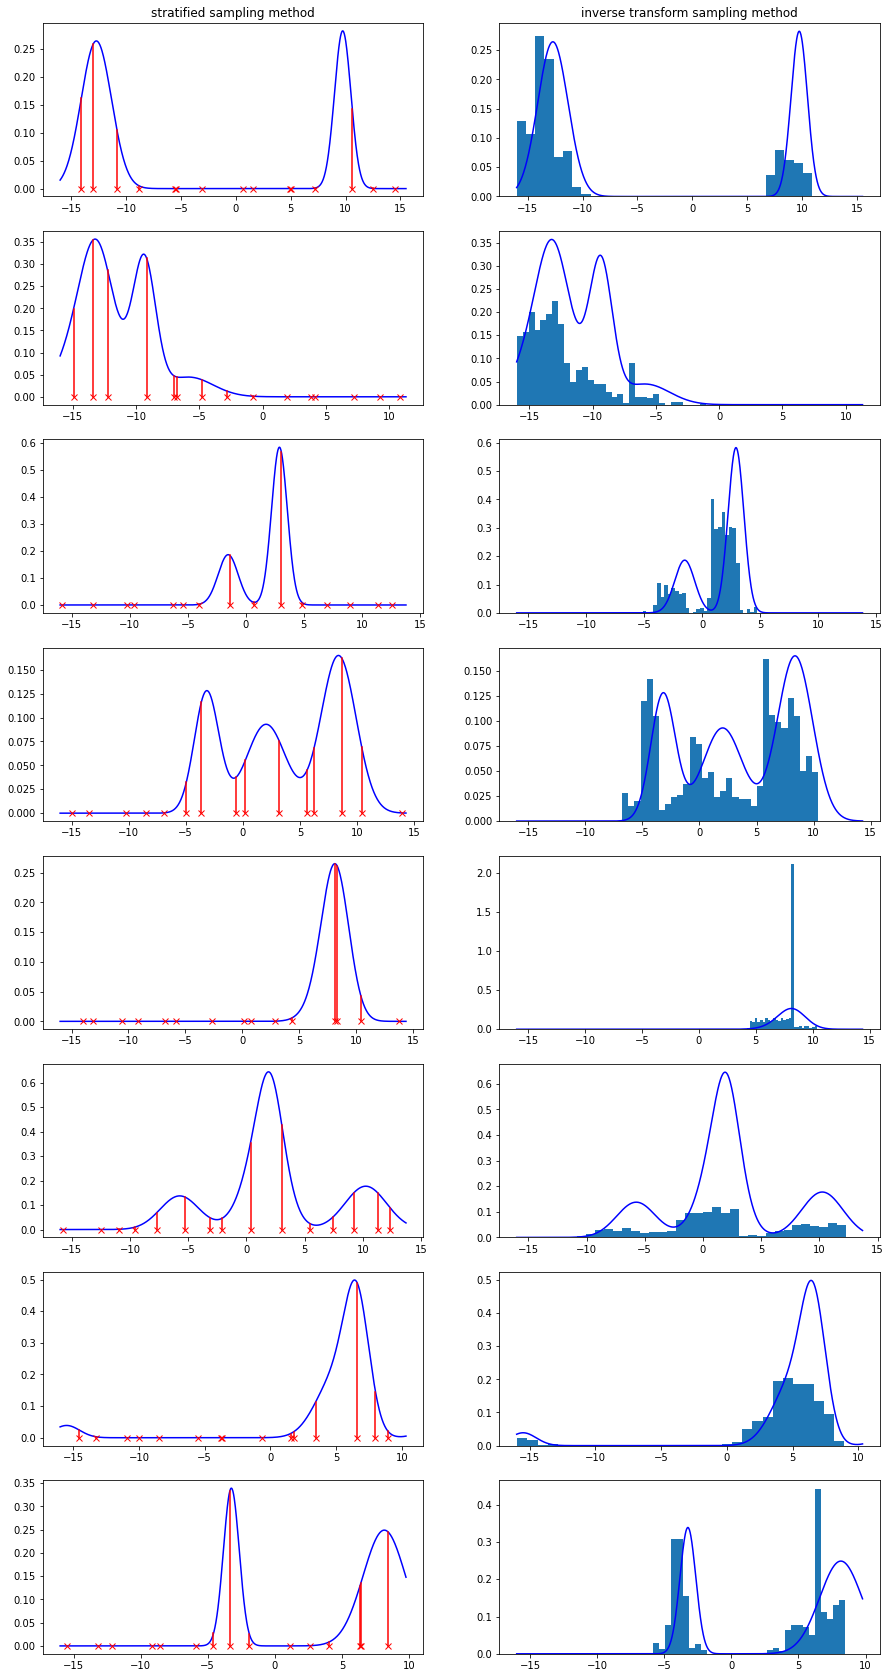

In [5]:
# use sample_pdf() to resample using inverse transform sampling method across multiple batches
dists = [RandDistribution() for _ in range(8)]
N = 16
should_jiggle_samples = True
domains = []
for _ in range(8):
    scale = random.uniform(25, 32)
    domains.append((-16, -16 + scale))

fig, axes = plt.subplots(8, 2, figsize=(15, 30))
axes = axes.ravel()

# plot the PDF
X = []
Y = []


for i, dist in enumerate(dists):
    z = np.linspace(*domains[i], 1000)
    y = dist(z)
    axes[2*i].plot(z, y, "-b", label="alpha compositing weight $w$")
    axes[2*i + 1].plot(z, y, "-b", label="alpha compositing weight $w$")
    
    x = np.linspace(*domains[i], N)
    if should_jiggle_samples:
        x = np.random.uniform(low=x[:-1] , high=x[1:])
    y = dist(x)
    axes[2*i].plot(x, np.zeros(x.size), "rx", label="coarse sampling")
    h = np.vstack((np.zeros(x.size)[None], y[None])).T
    for _x, _h in zip(x, h):
        axes[2*i].plot([_x, _x], _h, "-r")
    X.append(x)
    Y.append(y)

# in_shape - batch shape to test
in_shape = (2, 2, 2,)
X = np.stack(X).reshape(in_shape + ( -1,))
# X has shape (..., N)
X = np.concatenate((np.full(in_shape + (1,), -16), X), -1)
# Y has shape (..., N-1)
Y = np.stack(Y).reshape(in_shape + (-1,))
print("in shape", X.shape, Y.shape)

should_histogram = True
if should_histogram:
    M = 1000
else:
    M = 16

Z = sample_pdf(torch.tensor(X), torch.tensor(Y), M, det=False)
print("out shape", Z.shape)
X = X.reshape((math.prod(in_shape), -1))
Z = Z.numpy().reshape((math.prod(in_shape), -1))

if should_histogram:
    for i, z in enumerate(Z):
        axes[2*i + 1].hist(z, bins=32, density=True)
    
else:
    for i, z in enumerate(Z):
        axes[2*i + 1].plot(z, np.zeros(z.size), "mx", label="fine sampling")

axes[0].set_title("stratified sampling method")
axes[1].set_title("inverse transform sampling method")
None

(-1.0, 2.0)

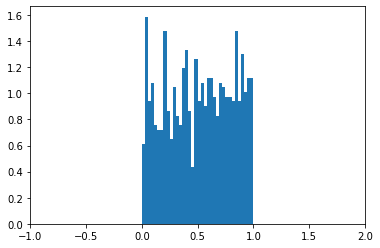

In [179]:
# uniform
x = np.random.uniform(0, 1, size=1000)
ax = plt.gca()
ax.hist(x, bins=36, density=True)
ax.set_xlim([-1, 2])

(-5.0, 5.0)

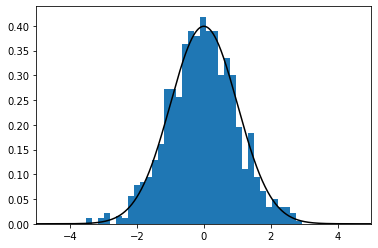

In [3]:
# normal
x = np.random.normal(loc=0.0, scale=1.0, size=1000)
ax = plt.gca()
ax.hist(x, bins=36, density=True)

x = np.linspace(-5, 5, 1000)
y = (1 / np.sqrt(2*np.pi))*np.exp(-x**2/2)
ax.plot(x, y, c="k")

ax.set_xlim([-5, 5])

(0.0, 50.0)

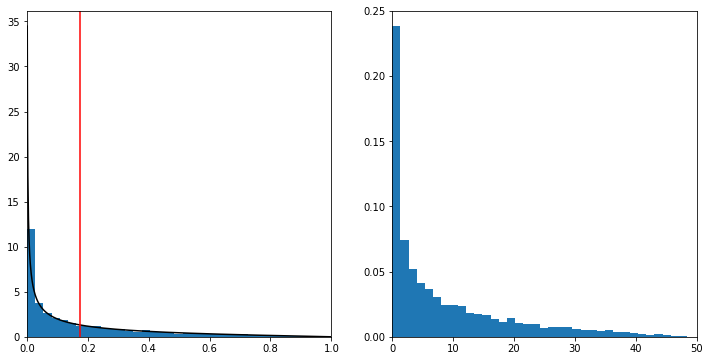

In [11]:
# beta distribution
# Based on
# https://www.desmos.com/calculator/pct1rbpkgv
# gamma function is G(z) = integrate{0, infty} t^{z-1} e^{-t} dt
# beta PDF is f(x;a,b) = G(a+b)/[G(a)G(b)] x^{a - 1}(1-x)^{b-1}

a = 0.4; b = 1.9
x = np.random.beta(a, b, size=10000)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
ax.hist(x, bins=36, density=True)

_x = np.linspace(0.001, 0.999, 1000)
y = _x**(a - 1) * (1 - _x)**(b - 1) / scipy.special.beta(a, b)
ax.plot(_x, y, c="k")

plt.axvline(x=1/(1 + b/a), color="r", label="mean")

ax.set_xlim([0, 1])

ax = fig.add_subplot(122)
u = 0; v = 50
x = map_01_to_uv(u, v)(x)
ax = plt.gca()
ax.hist(x, bins=36, density=True)
ax.set_xlim([u, v])

(-20.0, 90.0)

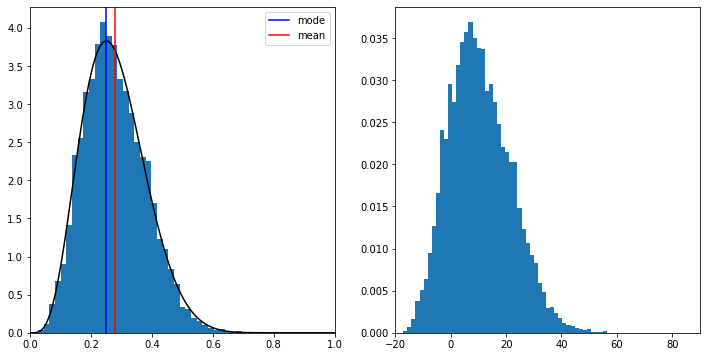

In [8]:
# beta with a mode
a = 5; b = 13
x = np.random.beta(a, b, size=10000)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
ax.hist(x, bins=36, density=True)

_x = np.linspace(0.001, 0.999, 1000)
y = _x**(a - 1) * (1 - _x)**(b - 1) / scipy.special.beta(a, b)
ax.plot(_x, y, c="k")

plt.axvline(x=(a - 1)/(a + b - 2), color="b", label="mode")
plt.axvline(x=1/(1 + b/a), color="r", label="mean")

ax.set_xlim([0, 1])
ax.legend()

ax = fig.add_subplot(122)
u = -20; v = 90
x = util.map_01_to_uv(u, v)(x)
ax = plt.gca()
ax.hist(x, bins=50, density=True)
ax.set_xlim([u, v])

(-1.0, 90.0)

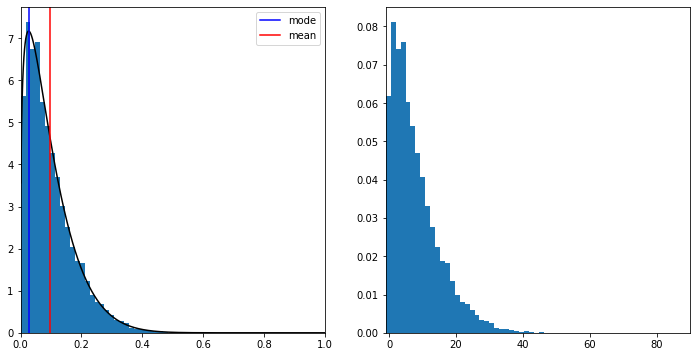

In [6]:
# beta with a mode
a = 1.3; b = 12
x = np.random.beta(a, b, size=10000)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
ax.hist(x, bins=36, density=True)

_x = np.linspace(0.001, 0.999, 1000)
y = _x**(a - 1) * (1 - _x)**(b - 1) / scipy.special.beta(a, b)
ax.plot(_x, y, c="k")

plt.axvline(x=(a - 1)/(a + b - 2), color="b", label="mode")
plt.axvline(x=1/(1 + b/a), color="r", label="mean")

ax.set_xlim([0, 1])
ax.legend()

ax = fig.add_subplot(122)
u = -1; v = 90
x = util.map_01_to_uv(u, v)(x)
ax = plt.gca()
ax.hist(x, bins=36, density=True)
ax.set_xlim([u, v])

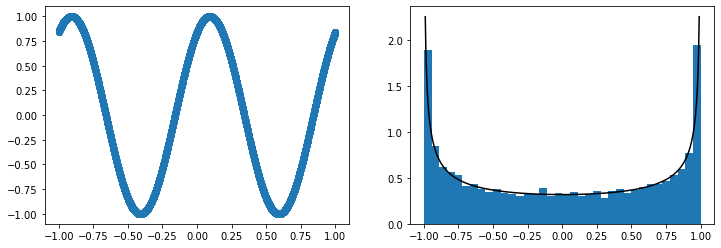

In [19]:
# Implicit Neural Representations with Periodic Activation Functions, SIREN
# https://arxiv.org/abs/2006.09661
# for a > \pi / 2 then and any b, if x ~ Unif[-1,1] and y = sin(ax+b) then y ~ Arcsine[-1,1]
N = 10000
x = np.random.uniform(low=-1, high=1, size=N)
a = 4 * np.pi / 2
b = 1
plt.figure(figsize=(12,4))
y = np.sin(a*x + b)

ax = plt.subplot(121)
ax.scatter(x, y)
ax = plt.subplot(122)
ax.hist(y, bins=36, density=True)

# Arcsine distribution
# https://en.wikipedia.org/wiki/Arcsine_distribution
x = np.linspace(-0.99, 0.99, 1000)
y = 1 /(np.pi * np.sqrt((x + 1)*(1 - x)))
ax.plot(x, y, c="k")

None